Nama : Stevani Dwi Utomo

NIM : 24/546969/PPA/06865

Struktur Code :
1. Setup dan Dataset AG News
2. Tokenisasi dan Dataset
3. Model RNN dan LSTM
4. Training & Evaluation Function (dengan metrik + visualisasi)
5. Eksperimen & Analisis


In [1]:
# %pip install --upgrade numpy gensim
%pip install torch==2.0.1 torchvision==0.15.2 torchaudio==2.0.2 --upgrade
# %pip install portalocker

# import os
# os.kill(os.getpid(), 9)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 64.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 112.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 124.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 67.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 31.9 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 120.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 65.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 45.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 101.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 MB 112.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.6/102.6 MB 101.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.

In [2]:
%wget http://nlp.stanford.edu/data/glove.6B.zip
%unzip glove.6B.zip -d glove.6B

UsageError: Line magic function `%wget` not found.


In [4]:
%pip install nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.7/781.7 kB 66.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import os
import nltk
from nltk.tokenize import word_tokenize
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
import seaborn as sns
import zipfile

nltk.download('punkt_tab')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#1. Load AG NEWS 
train_df = pd.read_csv("https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/train.csv", header=None)
test_df = pd.read_csv("https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/test.csv", header=None)
train_df.columns = ['label', 'title', 'text']
test_df.columns = ['label', 'title', 'text']
train_df['label'] -= 1
test_df['label'] -= 1
train_df['full_text'] = train_df['title'] + " " + train_df['text']
test_df['full_text'] = test_df['title'] + " " + test_df['text']

#2. Tokenize and Build Vocab
MAX_LEN = 100

def clean_and_tokenize(text):
    text = re.sub(r'[^\w\s]', '', text.lower())
    return word_tokenize(text)

all_tokens = [clean_and_tokenize(text) for text in train_df['full_text']]
vocab = {"<pad>": 0, "<unk>": 1}
for tokens in all_tokens:
    for token in tokens:
        if token not in vocab:
            vocab[token] = len(vocab)
inv_vocab = {v: k for k, v in vocab.items()}

#3. Load GloVe embeddings
def load_glove(path, dim):
    embeddings = np.random.uniform(-0.25, 0.25, (len(vocab), dim))
    found = 0
    with open(path, encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split()
            word = parts[0]
            if word in vocab:
                idx = vocab[word]
                vect = np.array(parts[1:], dtype=np.float32)
                embeddings[idx] = vect
                found += 1
    print(f"{found} words matched in GloVe.")
    return torch.tensor(embeddings, dtype=torch.float32)

glove_path = "glove.6B.100d.txt"
embed_dim = 100
embedding_matrix = load_glove(glove_path, embed_dim)

# 4. Encode dataset
def encode(text):
    tokens = clean_and_tokenize(text)
    ids = [vocab.get(token, vocab["<unk>"]) for token in tokens]
    if len(ids) < MAX_LEN:
        ids += [vocab["<pad>"]] * (MAX_LEN - len(ids))
    return torch.tensor(ids[:MAX_LEN])

class NewsDataset(Dataset):
    def __init__(self, df):
        self.data = [encode(text) for text in df['full_text']]
        self.labels = df['label'].tolist()
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

train_dataset = NewsDataset(train_df)
test_dataset = NewsDataset(test_df)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)


[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


57697 words matched in GloVe.


In [6]:
class RNNClassifier(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, num_classes):
        super().__init__()
        num_embeddings, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)
    def forward(self, x):
        x = self.embedding(x)
        out, hidden = self.rnn(x)
        self.last_hidden = hidden.squeeze(0)
        return self.fc(self.last_hidden)

class LSTMClassifier(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, num_classes):
        super().__init__()
        num_embeddings, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)
    def forward(self, x):
        x = self.embedding(x)
        out, (hidden, _) = self.lstm(x)
        self.last_hidden = hidden.squeeze(0)
        return self.fc(self.last_hidden)

In [7]:
def train_and_eval(model, train_loader, test_loader, epochs=5):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    train_losses, all_preds, all_labels = [], [], []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for x, y in train_loader:
            x, y = x.to(device), torch.tensor(y).to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)
        print(f"Epoch {epoch+1}: Loss={avg_loss:.4f}")

    model.eval()
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            out = model(x)
            pred = out.argmax(1).cpu()
            all_preds.extend(pred)
            all_labels.extend(y)
    report = classification_report(all_labels, all_preds, output_dict=True)
    print(classification_report(all_labels, all_preds))
    return train_losses, report, model

def plot_loss(rnn_loss, lstm_loss):
    plt.plot(rnn_loss, label="RNN")
    plt.plot(lstm_loss, label="LSTM")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    plt.legend()
    plt.show()



Training RNN...


/var/tmp/ipykernel_8995/3912231714.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x, y = x.to(device), torch.tensor(y).to(device)


Epoch 1: Loss=1.3889
Epoch 2: Loss=1.3776
Epoch 3: Loss=1.3789
Epoch 4: Loss=1.3828
Epoch 5: Loss=1.3719


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/m

              precision    recall  f1-score   support

           0       0.27      0.97      0.42      1900
           1       0.00      0.00      0.00      1900
           2       0.40      0.16      0.23      1900
           3       0.82      0.01      0.01      1900

    accuracy                           0.28      7600
   macro avg       0.37      0.28      0.17      7600
weighted avg       0.37      0.28      0.17      7600


Training LSTM...
Epoch 1: Loss=1.3852
Epoch 2: Loss=0.8713
Epoch 3: Loss=0.2387
Epoch 4: Loss=0.1692
Epoch 5: Loss=0.1165
              precision    recall  f1-score   support

           0       0.94      0.91      0.93      1900
           1       0.95      0.99      0.97      1900
           2       0.91      0.86      0.89      1900
           3       0.89      0.92      0.90      1900

    accuracy                           0.92      7600
   macro avg       0.92      0.92      0.92      7600
weighted avg       0.92      0.92      0.92      7600



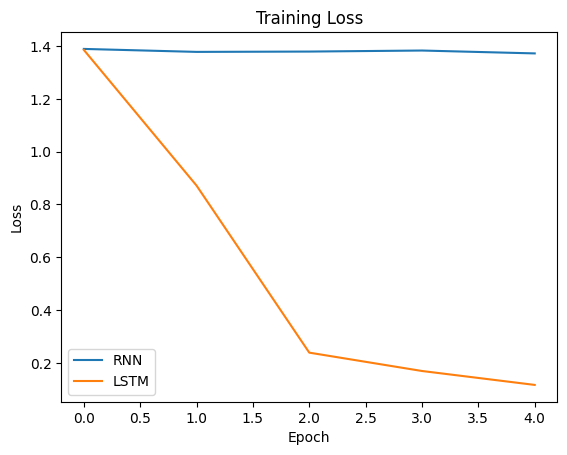

PRECISION | RNN: 0.3733, LSTM: 0.9213
RECALL | RNN: 0.2839, LSTM: 0.9213
F1-SCORE | RNN: 0.1660, LSTM: 0.9210


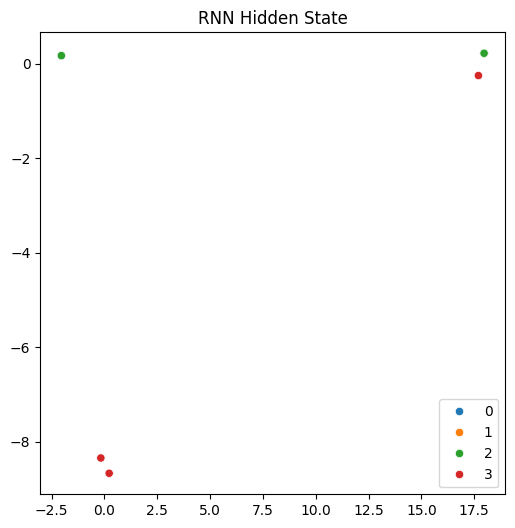

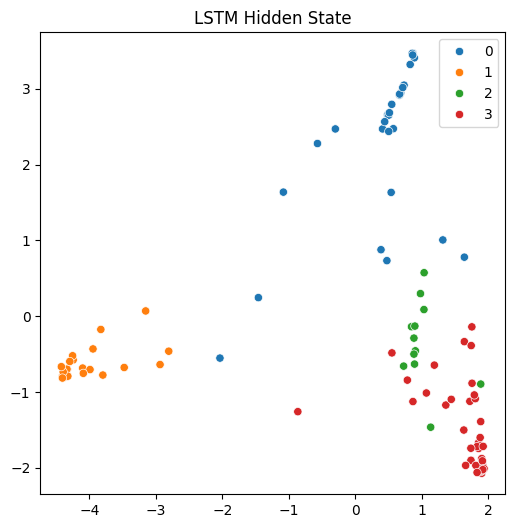

In [11]:
hidden_dim = 128
num_classes = 4

print("\nTraining RNN...")
rnn_model = RNNClassifier(embedding_matrix, hidden_dim, num_classes)
rnn_loss, rnn_report, rnn_model = train_and_eval(rnn_model, train_loader, test_loader)

print("\nTraining LSTM...")
lstm_model = LSTMClassifier(embedding_matrix, hidden_dim, num_classes)
lstm_loss, lstm_report, lstm_model = train_and_eval(lstm_model, train_loader, test_loader)

plot_loss(rnn_loss, lstm_loss)

def compare_metrics(rnn_report, lstm_report):
    for metric in ['precision', 'recall', 'f1-score']:
        print(f"{metric.upper()} | RNN: {rnn_report['macro avg'][metric]:.4f}, LSTM: {lstm_report['macro avg'][metric]:.4f}")
compare_metrics(rnn_report, lstm_report)

def visualize_hidden(model, dataset, title):
    model.eval()
    hidden_states, labels = [], []
    with torch.no_grad():
        for i in range(100):
            x, y = dataset[i]
            x = x.unsqueeze(0).to(device)
            _ = model(x)
            hidden_states.append(model.last_hidden.cpu().numpy().squeeze())
            labels.append(y)
    components = PCA(n_components=2).fit_transform(hidden_states)
    plt.figure(figsize=(6,6))
    sns.scatterplot(x=components[:,0], y=components[:,1], hue=labels, palette="tab10")
    plt.title(title)
    plt.show()

visualize_hidden(rnn_model, test_dataset, "RNN Hidden State")
visualize_hidden(lstm_model, test_dataset, "LSTM Hidden State")



Training RNN...


/var/tmp/ipykernel_8995/3912231714.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x, y = x.to(device), torch.tensor(y).to(device)


Epoch 1: Loss=1.3878
Epoch 2: Loss=1.3727
Epoch 3: Loss=1.3704
Epoch 4: Loss=1.3806
Epoch 5: Loss=1.3848


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/m

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1900
           1       0.28      0.08      0.13      1900
           2       0.26      0.75      0.39      1900
           3       0.38      0.32      0.35      1900

    accuracy                           0.29      7600
   macro avg       0.23      0.29      0.22      7600
weighted avg       0.23      0.29      0.22      7600


Training LSTM...
Epoch 1: Loss=1.2731
Epoch 2: Loss=0.2719
Epoch 3: Loss=0.1777
Epoch 4: Loss=0.1231
Epoch 5: Loss=0.0846
              precision    recall  f1-score   support

           0       0.89      0.94      0.91      1900
           1       0.97      0.94      0.96      1900
           2       0.90      0.87      0.89      1900
           3       0.89      0.90      0.90      1900

    accuracy                           0.91      7600
   macro avg       0.91      0.91      0.91      7600
weighted avg       0.91      0.91      0.91      7600



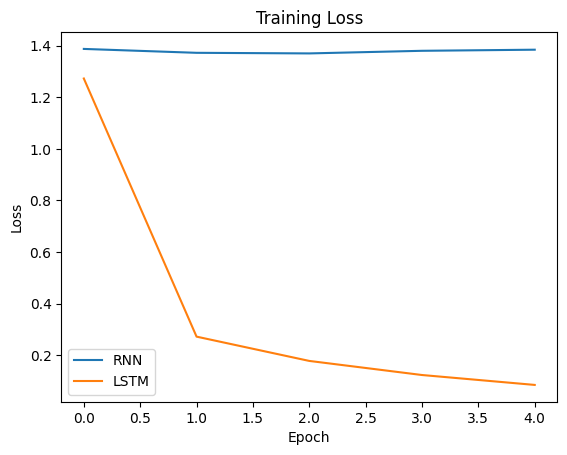

PRECISION | RNN: 0.2297, LSTM: 0.9137
RECALL | RNN: 0.2889, LSTM: 0.9129
F1-SCORE | RNN: 0.2161, LSTM: 0.9130


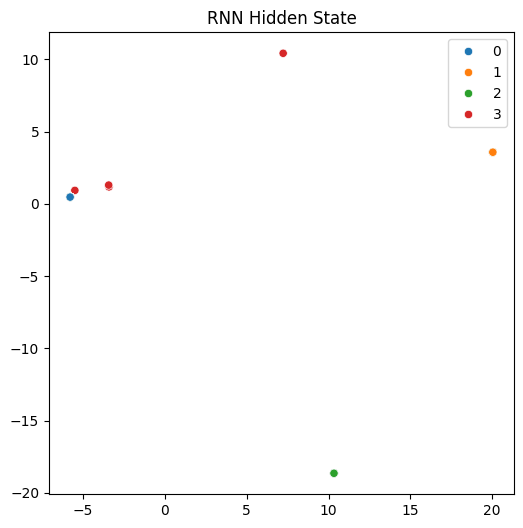

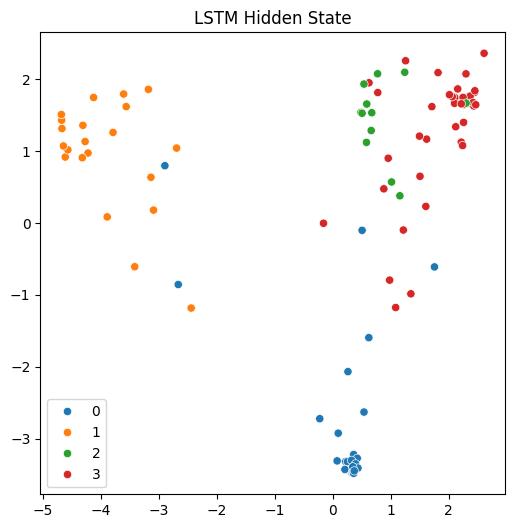

In [12]:
hidden_dim = 256
num_classes = 4

print("\nTraining RNN...")
rnn_model = RNNClassifier(embedding_matrix, hidden_dim, num_classes)
rnn_loss, rnn_report, rnn_model = train_and_eval(rnn_model, train_loader, test_loader)

print("\nTraining LSTM...")
lstm_model = LSTMClassifier(embedding_matrix, hidden_dim, num_classes)
lstm_loss, lstm_report, lstm_model = train_and_eval(lstm_model, train_loader, test_loader)

plot_loss(rnn_loss, lstm_loss)

def compare_metrics(rnn_report, lstm_report):
    for metric in ['precision', 'recall', 'f1-score']:
        print(f"{metric.upper()} | RNN: {rnn_report['macro avg'][metric]:.4f}, LSTM: {lstm_report['macro avg'][metric]:.4f}")
compare_metrics(rnn_report, lstm_report)

def visualize_hidden(model, dataset, title):
    model.eval()
    hidden_states, labels = [], []
    with torch.no_grad():
        for i in range(100):
            x, y = dataset[i]
            x = x.unsqueeze(0).to(device)
            _ = model(x)
            hidden_states.append(model.last_hidden.cpu().numpy().squeeze())
            labels.append(y)
    components = PCA(n_components=2).fit_transform(hidden_states)
    plt.figure(figsize=(6,6))
    sns.scatterplot(x=components[:,0], y=components[:,1], hue=labels, palette="tab10")
    plt.title(title)
    plt.show()

visualize_hidden(rnn_model, test_dataset, "RNN Hidden State")
visualize_hidden(lstm_model, test_dataset, "LSTM Hidden State")



Training RNN...


/var/tmp/ipykernel_8995/3912231714.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x, y = x.to(device), torch.tensor(y).to(device)


Epoch 1: Loss=1.3829
Epoch 2: Loss=1.3858
Epoch 3: Loss=1.3998
Epoch 4: Loss=1.4000
Epoch 5: Loss=1.4013


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/m

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1900
           1       0.25      0.90      0.39      1900
           2       0.00      0.00      0.00      1900
           3       0.39      0.16      0.22      1900

    accuracy                           0.26      7600
   macro avg       0.16      0.26      0.15      7600
weighted avg       0.16      0.26      0.15      7600


Training LSTM...
Epoch 1: Loss=1.0993
Epoch 2: Loss=0.2611
Epoch 3: Loss=0.1741
Epoch 4: Loss=0.1188
Epoch 5: Loss=0.0782
              precision    recall  f1-score   support

           0       0.92      0.92      0.92      1900
           1       0.97      0.98      0.98      1900
           2       0.89      0.86      0.88      1900
           3       0.88      0.90      0.89      1900

    accuracy                           0.92      7600
   macro avg       0.91      0.91      0.91      7600
weighted avg       0.91      0.92      0.91      7600



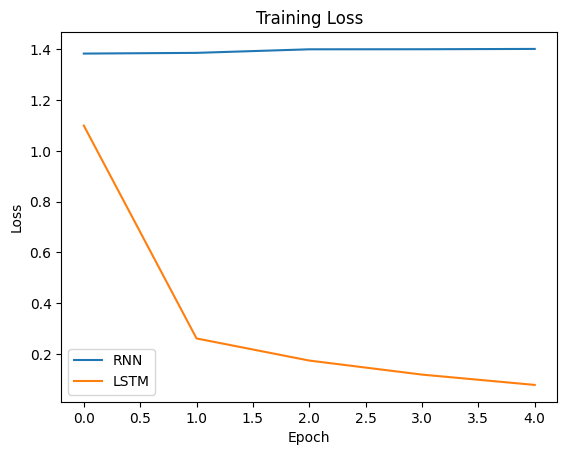

PRECISION | RNN: 0.1608, LSTM: 0.9148
RECALL | RNN: 0.2649, LSTM: 0.9150
F1-SCORE | RNN: 0.1539, LSTM: 0.9148


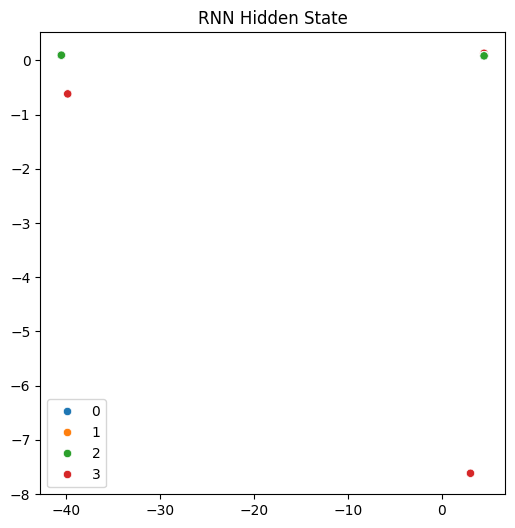

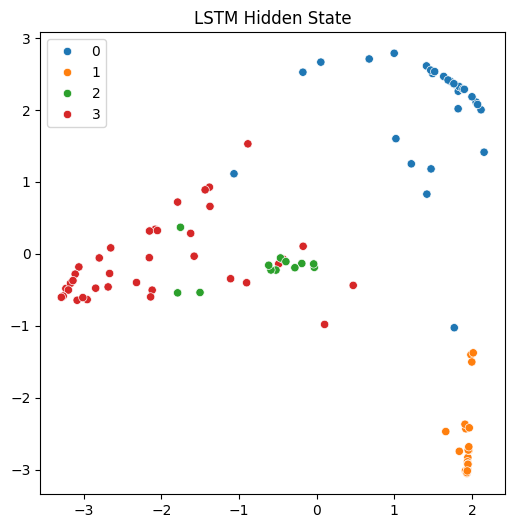

In [13]:
hidden_dim = 512
num_classes = 4

print("\nTraining RNN...")
rnn_model = RNNClassifier(embedding_matrix, hidden_dim, num_classes)
rnn_loss, rnn_report, rnn_model = train_and_eval(rnn_model, train_loader, test_loader)

print("\nTraining LSTM...")
lstm_model = LSTMClassifier(embedding_matrix, hidden_dim, num_classes)
lstm_loss, lstm_report, lstm_model = train_and_eval(lstm_model, train_loader, test_loader)

plot_loss(rnn_loss, lstm_loss)

def compare_metrics(rnn_report, lstm_report):
    for metric in ['precision', 'recall', 'f1-score']:
        print(f"{metric.upper()} | RNN: {rnn_report['macro avg'][metric]:.4f}, LSTM: {lstm_report['macro avg'][metric]:.4f}")
compare_metrics(rnn_report, lstm_report)

def visualize_hidden(model, dataset, title):
    model.eval()
    hidden_states, labels = [], []
    with torch.no_grad():
        for i in range(100):
            x, y = dataset[i]
            x = x.unsqueeze(0).to(device)
            _ = model(x)
            hidden_states.append(model.last_hidden.cpu().numpy().squeeze())
            labels.append(y)
    components = PCA(n_components=2).fit_transform(hidden_states)
    plt.figure(figsize=(6,6))
    sns.scatterplot(x=components[:,0], y=components[:,1], hue=labels, palette="tab10")
    plt.title(title)
    plt.show()

visualize_hidden(rnn_model, test_dataset, "RNN Hidden State")
visualize_hidden(lstm_model, test_dataset, "LSTM Hidden State")
